In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_68_face_landmarks.dat.bz2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/")

In [ ]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.applications import *
import keras.backend as K
import cv2
import os
import time
import FCN8s_keras as fcn
import numpy as np
import dlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import imutils
from imutils import face_utils

def Segmentation(path):
  PATH = path
  
  Predictor_path = '/content/shape_predictor_68_face_landmarks.dat'
  BASENAME = os.path.basename(PATH).split(".")[0]
  FOLDER_PATH = os.path.join(os.path.dirname(PATH),BASENAME) ####### PATH TO SAVE IMAGES

  if not os.path.exists(FOLDER_PATH):
    os.mkdir(FOLDER_PATH)

  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(Predictor_path)

  

  def Left_Cheek(im):
    left_cheek = [*range(6),48,60,49,31]
    left_cheek_cood = np.matrix([mat[x] for x in left_cheek])
    x,y,w,h = cv2.boundingRect(left_cheek_cood)
    #print(x,y,w,h)
    #plt.imshow()
    return im[y:y+h,x:x+w]

  def Right_Cheek(im):
    right_cheek = [*range(15,10,-1),54,64,53,35]
    right_cheek_cood = np.matrix([mat[x] for x in right_cheek])
    x,y,w,h = cv2.boundingRect(right_cheek_cood)

    return im[y:y+h,x:x+w]

  def Chin(im):
    chin = [*range(59,54,-1),*range(10,5,-1)]
    chin_cood = np.matrix([mat[x] for x in chin])
    x,y,w,h = cv2.boundingRect(chin_cood)

    return im[y:y+h,x:x+w]

  def Forehead(im):
    forehead = [17,26]
    length = mat[8][1] - mat[20][1]
    forehead_cood = np.matrix([mat[x] for x in forehead]+[(mat[17][0],mat[17][1]-50),(mat[26][0],mat[26][1]-50)])
    x,y,w,h = cv2.boundingRect(forehead_cood)
    print(x,y,w,h)
    return im[y:y+h,x:x+w]

  model = fcn.FCN()
  model.load_weights('/content/drive/MyDrive/Keras_FCN8s_face_seg_YuvalNirkin.h5')
  image1 = cv2.imread(PATH)
  
  im = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)


  im = fcn.auto_downscaling(im)
  input_im = fcn.vgg_preprocess(im)

  out = model.predict([input_im])
  out_resized = cv2.resize(np.squeeze(out), (im.shape[1],im.shape[0]))

  out_resized_clipped = np.clip(out_resized.argmax(axis=2), 0, 1).astype(np.float64)
  mask = cv2.GaussianBlur(out_resized_clipped, (7,7), 6)
  image = cv2.cvtColor((mask[:,:,np.newaxis]*im.astype(np.float64)).astype(np.uint8),cv2.COLOR_BGR2RGB)

  plt.imshow(image)
  cv2.imwrite(PATH.split(".")[0]+".jpg",image)

  test_img = image

  mat, d ,shape1= get_landmarks1(test_img)

  shape1 = face_utils.shape_to_np(shape1)
  mat = mat.tolist()
  #print(mat)

  LEFT_CHEEK = os.path.join(FOLDER_PATH,BASENAME+'_LEFTCHEEK.jpg')
  RIGHT_CHEEK = os.path.join(FOLDER_PATH,BASENAME+'_RIGHTCHEEK.jpg')
  CHIN = os.path.join(FOLDER_PATH,BASENAME+'_CHIN.jpg')
  FOREHEAD = os.path.join(FOLDER_PATH,BASENAME+'_FOREHEAD.jpg')

  x,y,w,h = cv2.boundingRect(shape1[0:27])
  plt.subplot(3,3,1)
  plt.imshow(test_img[y:y+h,x:x+w])

  remap_left_cheek = Left_Cheek(test_img)
  cv2.imwrite(LEFT_CHEEK,remap_left_cheek)
  plt.subplot(3,3,2)
  plt.imshow(remap_left_cheek)

  remap_right_cheek = Right_Cheek(test_img)
  cv2.imwrite(RIGHT_CHEEK,remap_right_cheek)
  plt.subplot(3,3,3)
  plt.imshow(remap_right_cheek)

  remap_chin = Chin(test_img)
  cv2.imwrite(CHIN,remap_chin)
  plt.subplot(3,3,4)
  plt.imshow(remap_chin)

  remap_foreheaad = Forehead(test_img)
  cv2.imwrite(FOREHEAD,remap_foreheaad)
  plt.subplot(3,3,5)
  plt.imshow(remap_foreheaad)
  plt.show()


In [ ]:
Segmentation("  IMAGE_PATH  ")

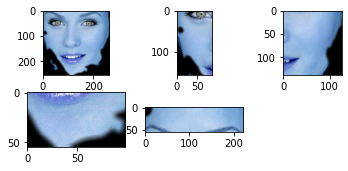